タイタニックデータをいい感じに整理できた
- Nameを接頭語で分類。いくつかを統一
- チケットの接頭文字で階級を分類
- 客室番号で分類
- 家族の人数、一人かどうかのカラムを追加

あとできそうなことは
- 統一したNameごとに年齢の平均をとって、それを各欠損データに入れる
- FareとかAgeとか一定区切りごとに分解  
とか

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb # 勾配ブースティング
import seaborn as sns # オシャレなグラフ
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


#Name列の整理
#正規表現で「(文字列).」の部分を抽出し、新たに作成する"Saluation"列に入れる　（Mr.とか入る）
#別表現の物を統一
#Mr,Miss,Mrs,Master,Rareにそれぞれ番号を振り、mappingする。満たさない奴はNanとなるのでそれを0で埋める
def Salutation(total_data):
    for dataset in total_data:
        dataset['Salutation'] = dataset.Name.str.extract(' ([A-Za-z]+).', expand=False) 
        dataset['Salutation'] = dataset['Salutation'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        dataset['Salutation'] = dataset['Salutation'].replace('Mlle', 'Miss')
        dataset['Salutation'] = dataset['Salutation'].replace('Ms', 'Miss')
        dataset['Salutation'] = dataset['Salutation'].replace('Mme', 'Mrs')
        Salutation_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 
        dataset['Salutation'] = dataset['Salutation'].map(Salutation_mapping)
        dataset['Salutation'] = dataset['Salutation'].fillna(0)
        dataset['Salutation'] = dataset['Salutation'].astype(int)
        
        
#Ticketの一番前の文字をTicket_Leftに格納
#apply:各要素に関数を適用
#無名関数lambda:要素xを入れて、一番前の文字を返す
def Ticket(total_data):
    for dataset in total_data:
        dataset['Ticket_Lett'] = dataset['Ticket'].apply(lambda x: str(x)[0])
        dataset['Ticket_Lett'] = dataset['Ticket_Lett'].apply(lambda x: str(x)) #文字型にしてるだけ
        dataset['Ticket_Len'] = dataset['Ticket'].apply(lambda x: len(x)) 
        dataset['Ticket_Lett'] = np.where((dataset['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), dataset['Ticket_Lett'],0) 
        dataset['Ticket_Lett']=dataset['Ticket_Lett'].replace("1",1).replace("2",2).replace("3",3).replace("0",0).replace("S",3).replace("P",0).replace("C",3).replace("A",3)
        
#客室番号で統一。A,C,Fで統一、B,D,Eで統一できるっぽい。
def Cabin(total_data):
    for dataset in total_data:
        dataset['Cabin_Lett'] = dataset['Cabin'].apply(lambda x: str(x)[0]) 
        dataset['Cabin_Lett'] = dataset['Cabin_Lett'].apply(lambda x: str(x))
        dataset['Cabin_Lett'] = np.where((dataset['Cabin_Lett']).isin([ 'F', 'E', 'D', 'C', 'B', 'A']),dataset['Cabin_Lett'], np.where((dataset['Cabin_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']), '0','0'))
        dataset['Cabin_Lett'] = dataset['Cabin_Lett'].replace("A",1).replace("B",2).replace("C",1).replace("0",0).replace("D",2).replace("E",2).replace("F",1)


#新しい変数「Family_size」導入
#Sibspは同乗する夫婦兄弟の数、Parchは同乗する親と子供の数より、
#Family_size = Sibsp + Parch + 1
def Family(total_data):
    for dataset in total_data:
        dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
        
def Drop(total_data):
    for dataset in total_data:
        dataset.drop(["Name","Ticket","Cabin","SibSp"],axis = 1,inplace=True)

In [2]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
total_data = [train,test]

for dataset in total_data:
    dataset["Embarked"].fillna("S",inplace=True)
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    dataset["Embarked"] = dataset["Embarked"].map( {"S":0,"C":1,"Q":2}).astype(int)

In [3]:
Salutation(total_data)
Ticket(total_data)
Cabin(total_data)
Family(total_data)
Drop(total_data)

train["Age"] = np.where((train["Age"].isnull()) & (train["Salutation"] == 0),30.934783,train["Age"])
train["Age"] = np.where((train["Age"].isnull()) & (train["Salutation"] == 1),32.389610,train["Age"])
train["Age"] = np.where((train["Age"].isnull()) & (train["Salutation"] == 2),21.917808,train["Age"])
train["Age"] = np.where((train["Age"].isnull()) & (train["Salutation"] == 3),36.066667,train["Age"])
train["Age"] = np.where((train["Age"].isnull()) & (train["Salutation"] == 4),4.574167,train["Age"])
train["Age"] = np.where((train["Age"].isnull()) & (train["Salutation"] == 5),45.894737,train["Age"])

test["Age"] = np.where((test["Age"].isnull()) & (test["Salutation"] == 0),30.227273,test["Age"])
test["Age"] = np.where((test["Age"].isnull()) & (test["Salutation"] == 1),32.050847,test["Age"])
test["Age"] = np.where((test["Age"].isnull()) & (test["Salutation"] == 2),21.644286,test["Age"])
test["Age"] = np.where((test["Age"].isnull()) & (test["Salutation"] == 3),39.050000,test["Age"])
test["Age"] = np.where((test["Age"].isnull()) & (test["Salutation"] == 4),7.1506250,test["Age"])
test["Age"] = np.where((test["Age"].isnull()) & (test["Salutation"] == 5),44.800000,test["Age"])

test["Fare"].fillna(test["Fare"].mean(),inplace=True)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Salutation,Ticket_Lett,Ticket_Len,Cabin_Lett,FamilySize,IsAlone
0,1,0,3,1,22.0,0,7.2500,0,1,3,9,0,2,0
1,2,1,1,0,38.0,0,71.2833,1,3,0,8,1,2,0
2,3,1,3,0,26.0,0,7.9250,0,2,3,16,0,1,1
3,4,1,1,0,35.0,0,53.1000,0,3,1,6,1,2,0
4,5,0,3,1,35.0,0,8.0500,0,1,3,6,0,1,1


In [5]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [6]:
# 年齢を５つのグループに分ける
for dataset in total_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    dataset['Age'] = dataset['Age'].astype(int)

    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)


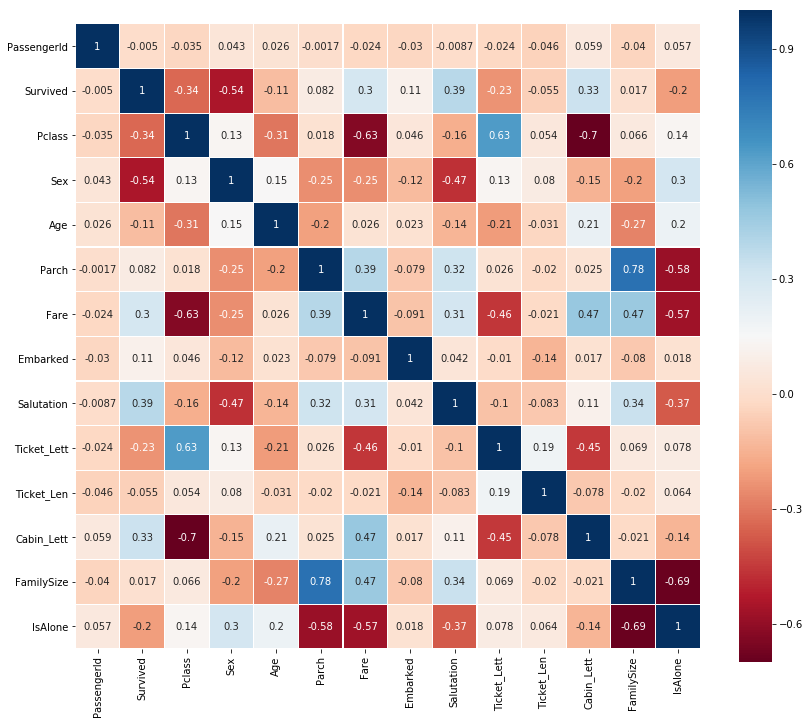

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor="white",annot=True)

In [8]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Salutation,Ticket_Lett,Ticket_Len,Cabin_Lett,FamilySize,IsAlone
0,1,0,3,1,1,0,0,0,1,3,9,0,2,0
1,2,1,1,0,2,0,3,1,3,0,8,1,2,0
2,3,1,3,0,1,0,1,0,2,3,16,0,1,1
3,4,1,1,0,2,0,3,0,3,1,6,1,2,0
4,5,0,3,1,2,0,1,0,1,3,6,0,1,1
